<a href="https://colab.research.google.com/github/manola1109/Web-Traffic-Forecasting---Building-a-deep-learning-model-for-time-series-data./blob/main/Forecasting_Web_Traffic_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Web Traffic Forecasting

(This notebook will help you understand how to formulate and build a deep learning model for time series data.)


## Understanding the Problem Statement
In order to dynamically manage resources to run your website, you need to have an idea about the number of visitors who might arrive at your website at different points in time. So, the problem at hand is to predict the web traffic or number of sessions in the next hour based on the historical data.

## Load Dataset

Let us load the dataset first.

In [1]:
import pandas as pd
import numpy as np

data=pd.read_csv('webtraffic.csv')

Check the shape of the data

In [2]:
data.shape

(4896, 2)

Take a glance at the first 5 rows

In [3]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


## Data Exploration

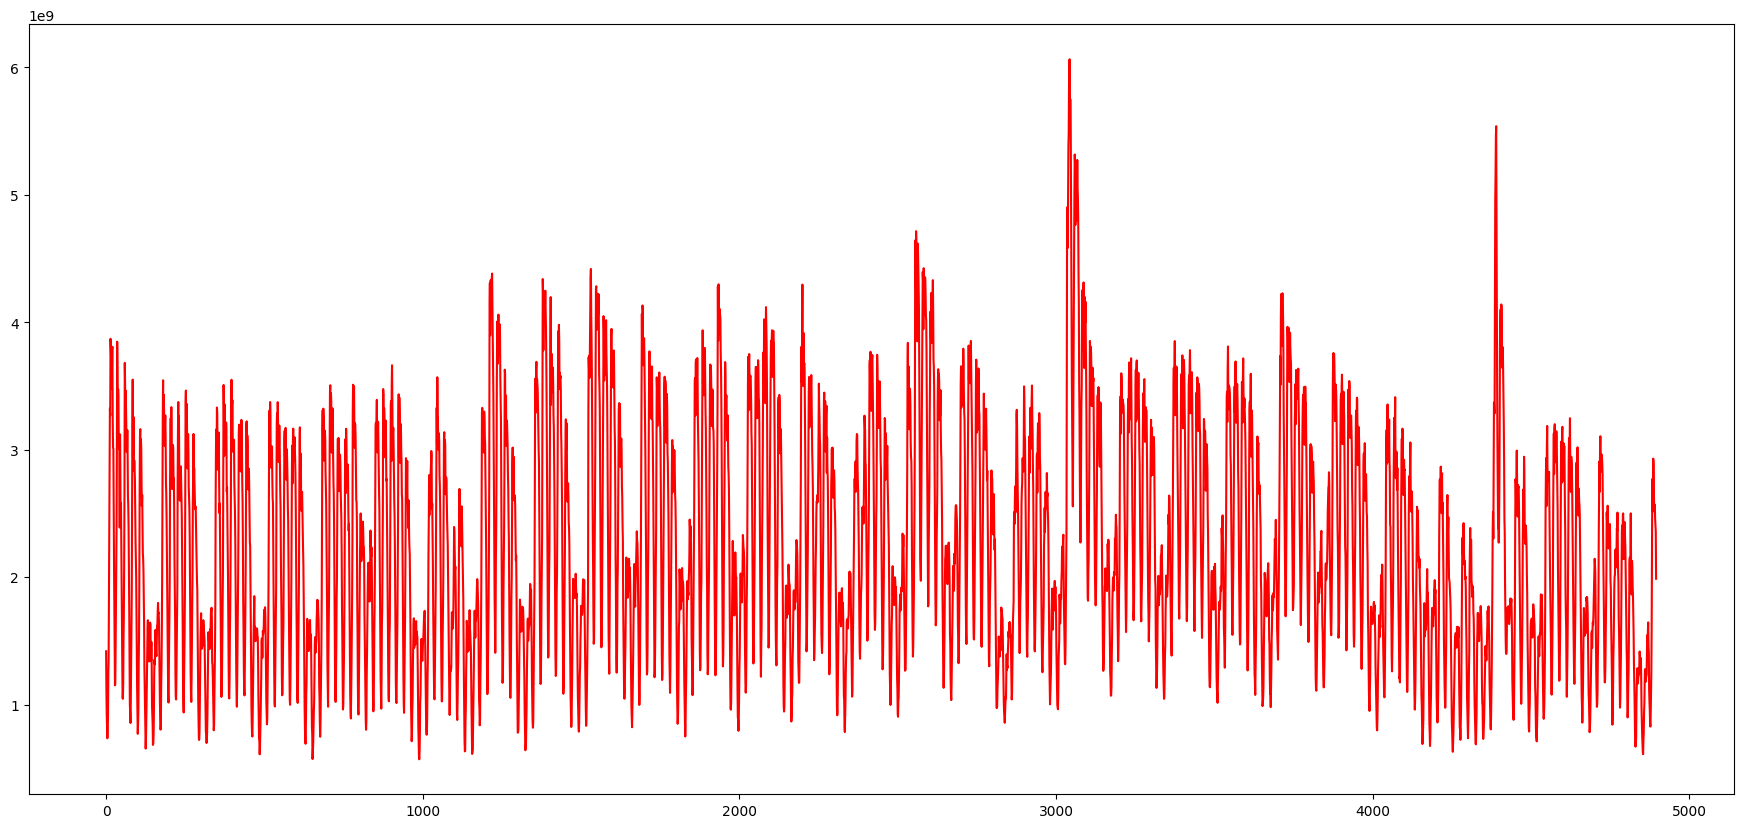

In [4]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

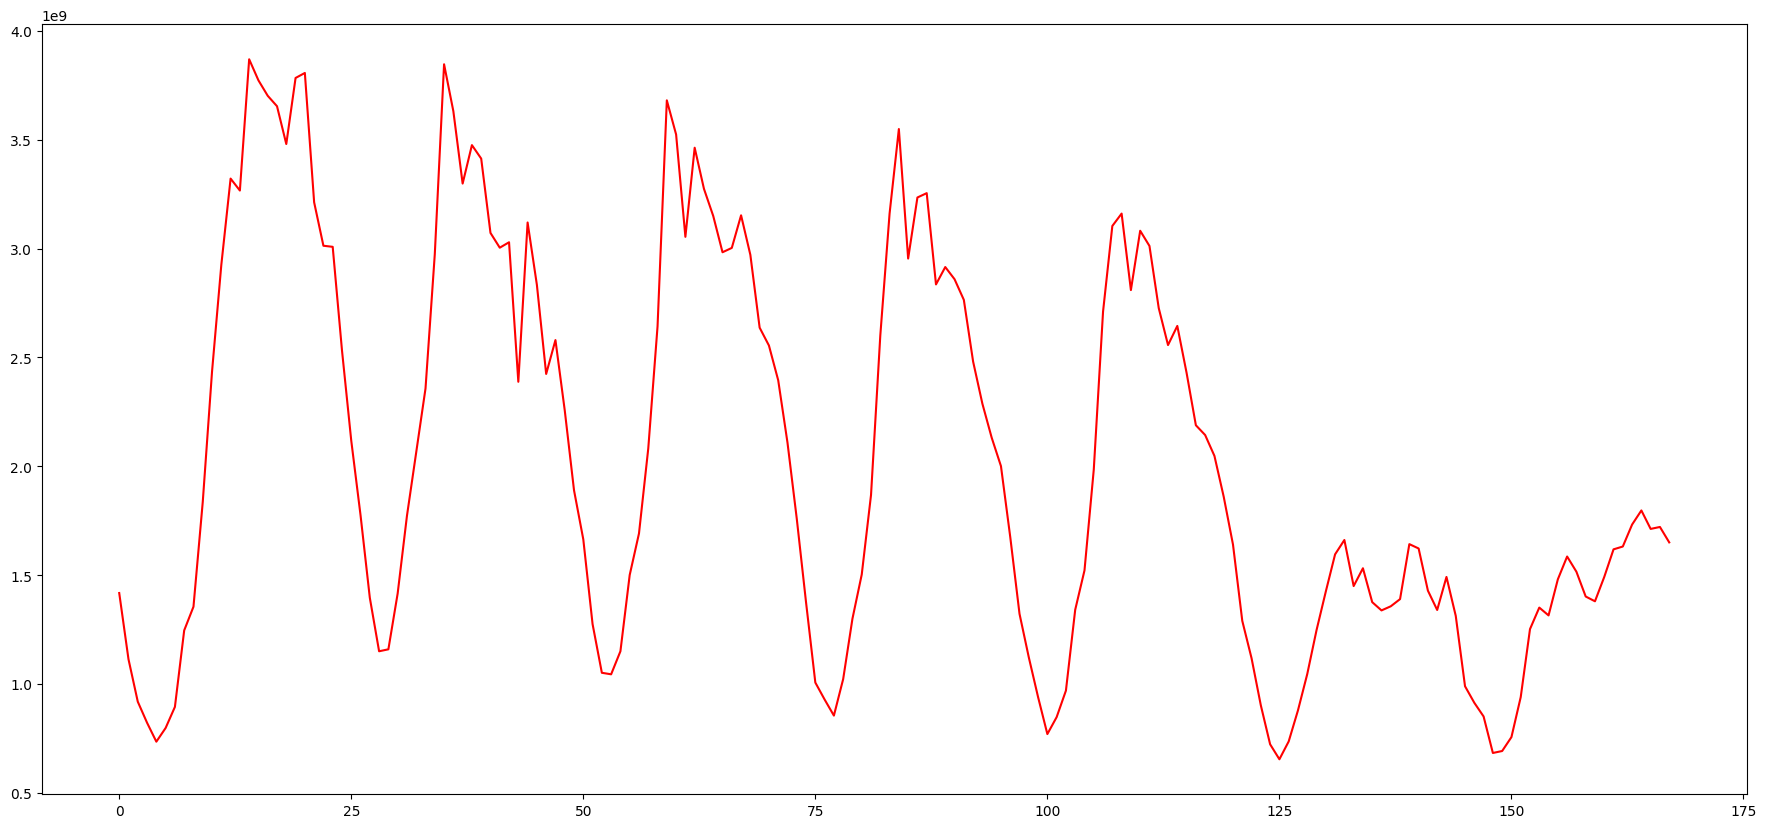

In [5]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

## Data Preparation

We will model the problem to predict the traffic for the next hour based on the previous week data i.e. 168 hours. Lets define a function to prepare the input and output data accordingly.

*Note: The input is a sequence of values and the output is a single value.*

In [6]:
def prepare_data(seq,num):
  x=[]
  y=[]

  for i in range(0,(len(seq)-num),1):

    input_ = seq[i:i+num]
    output  = seq[i+num]

    x.append(input_)
    y.append(output)

  return np.array(x), np.array(y)

Call the function

In [7]:
num=168
x,y= prepare_data(sessions,num)

In [8]:
print(len(x))

4728


No. of input sequences is around 4700

In [9]:
x[0]

array([1418159421, 1113769116,  919158921,  822352824,  735526737,
        798400800,  895206897, 1246503249, 1355285358, 1836321840,
       2435122440, 2925140931, 3321347328, 3266457273, 3869249877,
       3772443780, 3701585709, 3653681661, 3480029487, 3783421791,
       3806375814, 3212565219, 3012965019, 3007975014, 2532926538,
       2117758122, 1775443779, 1396203399, 1150695153, 1159677162,
       1416163419, 1772449776, 2063866068, 2357278362, 2974042980,
       3846295854, 3630727638, 3298393305, 3475039482, 3413163420,
       3071847078, 3003983010, 3028933035, 2388216393, 3119751126,
       2833324839, 2424144429, 2579832585, 2257478262, 1890213894,
       1664665668, 1275445278, 1051893054, 1044907047, 1150695153,
       1500993504, 1691611695, 2081830086, 2642706648, 3680627688,
       3523941531, 3053883060, 3463063470, 3274441281, 3149691156,
       2983024989, 3002985009, 3152685159, 2971048977, 2636718642,
       2554882560, 2395202400, 2108776113, 1759475763, 1375245

In [10]:
y[0]

np.int64(1427141430)

Split the dataset into training and validation data

In [11]:
ind = int(0.9 * len(x))

x_tr = x[:ind]
y_tr = y[:ind]

x_val=x[ind:]
y_val=y[ind:]

Normalize the input and output data as it speeds up the training process




In [12]:
from sklearn.preprocessing import StandardScaler

#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [17]:
print(x_tr.shape)

(4255, 168, 1)


As you can see here, the input data is a 2 dimenional array but the LSTM and Conv1D accepts only 3 dimensional inputs in the form of (no. of samples, no. of timesteps, no. of features)

So, reshaping the input data as per the model requirement

In [18]:
#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)

In [19]:
print(x_tr.shape)

(4255, 168, 1)


Now, the data is ready for model training.

<br>

## Model Building

Define the model architecture

In [20]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

model= Sequential()

model.add(Conv1D(64, 3, padding='same', activation='relu',input_shape=(num,1)))

model.add(Conv1D(32, 5, padding='same', activation='relu',input_shape=(num,1)))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

Understand the output shape and no. of parameters of each layer

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 168, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 168, 32)           10272     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5376)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                344128    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 354,721
Trainable params: 354,721
Non-trainable params: 0
_________________________________________________________________


Define the optimizer and loss:

In [21]:
model.compile(loss='mse',optimizer='adam')

Define the callback to save the best model during the training

In [23]:
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Train the model for 30 epochs with batch size of 32:

In [24]:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2015
Epoch 1: val_loss improved from inf to 0.04394, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2007 - val_loss: 0.0439
Epoch 2/30
111/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 2: val_loss improved from 0.04394 to 0.02532, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - val_loss: 0.0253
Epoch 3/30
118/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 3: val_loss improved from 0.02532 to 0.02125, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0213
Epoch 4/30
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 4: val_loss improved from 0.02125 to 0.01912, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0191
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 5: val_loss improved 

Load the weights of best model prior to predictions

In [26]:
# Load the weights of best model prior to predictions
# Change the filename to match the one used in ModelCheckpoint
model.load_weights('best_model.keras')

Evaluate the performance of model on the validation data

In [27]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 
Mean Square Error: 0.014523574151098728


## Comparision with the baseline model

In [28]:
#build a simple model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [29]:
x_reshaped = x_val.reshape(-1,168)
y_pred = compute_moving_average(x_reshaped)

In [30]:
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print(mse)

0.5546025834434455


## Forecasting

**Steps to Follow**:

1. Intialize the array, say "data" with a weeks data
2. Predict for the next hour
3. Append the predicted value as the last element of array "data"
4. Skip the first element of array "data"
5. Repeat steps 2 to 4 for **N** iterations

Define a function which forecasts the traffic for the next hours from the previous week data.

In [31]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]

  #intialize the array with previous weeks data
  temp=x_val[ind]

  for i in range(no_of_pred):

    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]

    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)

    #ignore the first element of array
    temp = temp[1:]

  return predictions

Its time to forecast the traffic for the next 24 hours based on the previous week data

In [32]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [33]:
y_true = y_val[ind:ind+(no_of_pred)]

Lets convert back the normalized values to the original dimensional space

In [35]:
# Convert back the normalized values to the original dimensional space
y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)) # Reshape y_true to be 2D
y_pred = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)) # Reshape y_pred to be 2D. Also convert y_pred to numpy array as it is a list.

In [36]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

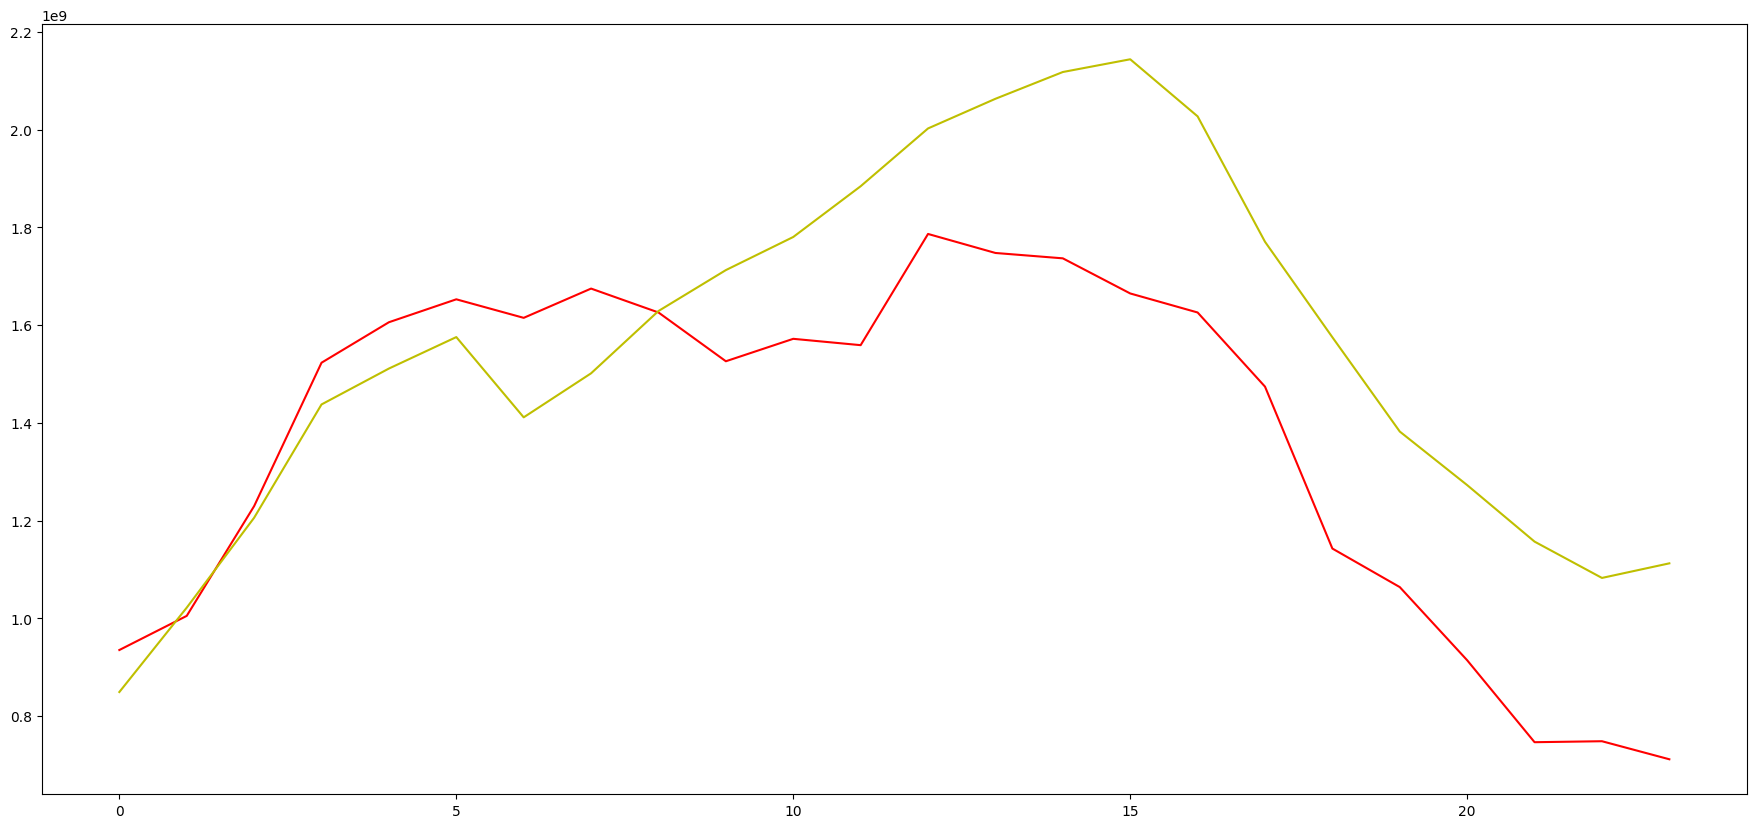

In [37]:
plot(y_true,y_pred)

Wow, Thats Amazing. The forecasted values are almost close to the actual values.

## How to improve the Model Performance?

1. We can make the time series data stationary
2. Try different number of hidden units
3. Change the learning rate